# Train SVM classifier with FER2013 dataset


## Initializing and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install specific sklearn version.
!pip install scikit-learn==1.2.1

In [ ]:
# Import remaining packages.
import time
import os
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
# Check Python and packages version.
!python3 --version
print("numpy: "+np.__version__)
print("sklearn: "+sklearn.__version__)

Python 3.9.16
numpy: 1.22.4
sklearn: 1.2.2


## Hyperparameter definition

In [ ]:
# Set training hyperparameters.
class Dataset:
    name = '_'
    train_folder = '_'
    validation_folder = '_'
    test_folder = '_'
    trunc_trainset_to = -1
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Hyperparams:
    random_state = 0
    epochs = 10000
    kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
    decision_function = 'ovr'  #'ovo' for OneVsOne and 'ovr' for OneVsRest'
    features = 'landmarks' # 'landmarks', 'hog' or 'landmarks_and_hog'
    gamma = 0.0001
    C = 10 

class Training:
    save_model = True
    save_model_path = '_'

DATASET = Dataset()
TRAINING = Training()
HYPERPARAMS = Hyperparams()

## Definition of functions

### Load data into classifier

In [ ]:
# Definition of dfunction for loading the data.
def load_data(validation=False, test=False): # Specify the data to be loaded (train data will be loaded by default).
    
    train_dict = dict() # Will store the training data.
    validation_dict = dict() # Will store the validation data.
    test_dict = dict() # Will store the test data.

    if DATASET.name == "FER2013": # Change name of dataset if needed.

        # Load train set.
        if HYPERPARAMS.features == "landmarks_and_hog": # Load training landmarks and hog features.
            train_dict['X'] = np.load(DATASET.train_folder + '/landmarks.npy')
            train_dict['X'] = np.array([x.flatten() for x in train_dict['X']]) # Flatten 2D array (X and Y facial landmark coordinates) into 1D array (represent images in 1D 
                                                                             # to be feeded to the SVC)
            train_dict['X'] = np.concatenate((train_dict['X'], np.load(DATASET.train_folder + '/hog_features.npy')), axis=1) # Join landmaks and hog features array.
        elif HYPERPARAMS.features == "landmarks": # Load training landmarks.
            train_dict['X'] = np.load(DATASET.train_folder + '/landmarks.npy')
            train_dict['X'] = np.array([x.flatten() for x in train_dict['X']])
        elif HYPERPARAMS.features == "hog": # Load training hog features
            train_dict['X'] = np.load(DATASET.train_folder + '/hog_features.npy')
        else:
            print( "Error '{}' features not recognized".format(HYPERPARAMS.features))
        train_dict['Y'] = np.load(DATASET.train_folder + '/labels.npy') # Load training labels.
        if DATASET.trunc_trainset_to > 0: # If not available data is selected for training, select, for X and Y, only the first desired number of features.
            train_dict['X'] = train_dict['X'][0:DATASET.trunc_trainset_to, :]
            train_dict['Y'] = train_dict['Y'][0:DATASET.trunc_trainset_to]
        
        # Load validation set. 
        if validation:
            if HYPERPARAMS.features == "landmarks_and_hog": # Load validation landmarks and hog features.
                validation_dict['X'] = np.load(DATASET.validation_folder + '/landmarks.npy')
                validation_dict['X'] = np.array([x.flatten() for x in validation_dict['X']])
                validation_dict['X'] = np.concatenate((validation_dict['X'], np.load(DATASET.validation_folder + '/hog_features.npy')), axis=1)
            elif HYPERPARAMS.features == "landmarks":  # Load validation landmarks.
                validation_dict['X'] = np.load(DATASET.validation_folder + '/landmarks.npy')
                validation_dict['X'] = np.array([x.flatten() for x in validation_dict['X']])
            elif HYPERPARAMS.features == "hog": # Load validation hog features.
                validation_dict['X'] = np.load(DATASET.validation_folder + '/hog_features.npy')
            else:
                print( "Error '{}' features not recognized".format(HYPERPARAMS.features))
            validation_dict['Y'] = np.load(DATASET.validation_folder + '/labels.npy') # Load validation labels.
            if DATASET.trunc_validationset_to > 0: 
                validation_dict['X'] = validation_dict['X'][0:DATASET.trunc_validationset_to, :]
                validation_dict['Y'] = validation_dict['Y'][0:DATASET.trunc_validationset_to]
        
        # Load test set.
        if test:
            if HYPERPARAMS.features == "landmarks_and_hog": # Load test landmarks and hog features.
                test_dict['X'] = np.load(DATASET.test_folder + '/landmarks.npy')
                test_dict['X'] = np.array([x.flatten() for x in test_dict['X']])
                test_dict['X'] = np.concatenate((test_dict['X'], np.load(DATASET.test_folder + '/hog_features.npy')), axis=1)
            elif HYPERPARAMS.features == "landmarks": # Load test landmarks.
                test_dict['X'] = np.load(DATASET.test_folder + '/landmarks.npy')
                test_dict['X'] = np.array([x.flatten() for x in test_dict['X']])
            elif HYPERPARAMS.features == "hog": # Load test hog features.
                test_dict['X'] = np.load(DATASET.test_folder + '/hog_features.npy')
            else:
                print( "Error '{}' features not recognized".format(HYPERPARAMS.features))
            test_dict['Y'] = np.load(DATASET.test_folder + '/labels.npy') # Load test labels.
            np.save(DATASET.test_folder + "/lab.npy", test_dict['Y'])
            if DATASET.trunc_testset_to > 0:
                test_dict['X'] = test_dict['X'][0:DATASET.trunc_testset_to, :]
                test_dict['Y'] = test_dict['Y'][0:DATASET.trunc_testset_to]

        # Conditions to specify the data to be returned by the function.
        if not validation and not test:
            return train_dict
        elif not test:
            return train_dict, validation_dict
        else: 
            return train_dict, validation_dict, test_dict
   
    # If the name of the dataset is unknown.
    else:
        print( "Unknown dataset")
        exit()

### Evaluation

In [ ]:
# Definition of function to evaluate the model.
def evaluate(model, X, Y):
        predicted_Y = model.predict(X)
        accuracy = accuracy_score(Y, predicted_Y)
        return accuracy

### Training

In [ ]:
# Definition of function for training the SVC.
def train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, decision_function=HYPERPARAMS.decision_function, 
          gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C, train_model=True):

        print( "loading dataset " + DATASET.name + "...") # Print to know that the training has loaded the dataset.
        if train_model: # To initiate training phase 'train_model' = True
                train, validation = load_data(validation=True) # Load the dataset by calling the 'load_data' function.
        else: # To initiate testing phase 'train_model' = False
                train, validation, test = load_data(validation=True, test=True)
        
        if train_model:
            # Training phase.
            print( "building model...") # To know training has began.
            model = SVC(random_state=random_state, max_iter=epochs, kernel=kernel, decision_function_shape=decision_function, gamma=gamma, C=HYPERPARAMS.C) # Definition of the classifier.

            print( "start training...") # Print to know that the training has began.
            print( "--")
            print( "kernel: {}".format(kernel))
            print( "decision function: {} ".format(decision_function))
            print( "max epochs: {} ".format(epochs))
            print( "gamma: {} ".format(gamma))
            print( "C: {} ".format(C))            
            print( "--")
            print( "Training samples: {}".format(len(train['Y'])))
            print( "Validation samples: {}".format(len(validation['Y']))) # Print to know validation has begun.
            print( "--")
            start_time = time.time() # Begin count to measure the duration of the training.
            model.fit(train['X'], train['Y']) # Fit the model to the training data.
            training_time = time.time() - start_time # Calculate real-time duration.
            print( "training time = {0:.1f} sec".format(training_time)) # Print the duration obtained.

            if TRAINING.save_model: # Save model.
                print( "saving model...")
                with open(TRAINING.save_model_path, 'wb') as f:
                        pickle.dump(model, f)            

            # Check training accuracy.
            print( "evaluating...") # Print to know that the evaluation of training has began.
            training_accuracy = evaluate(model, train['X'], train['Y'])
            print( "  - training accuracy = {0:.1f}".format(training_accuracy*100)) # Print accuracy.

            # Validation phase.
            print( "evaluating...") # Print to know that the validation has began.
            start_time = time.time() # Begin count to measure the duration of the validation.            
            validation_accuracy = evaluate(model, validation['X'], validation['Y']) # Start validation by calling the 'evaluate' function.
            validation_time = time.time() - start_time # Calculate real-time duration.            
            print( "  - validation accuracy = {0:.1f}".format(validation_accuracy*100)) # Print accuracy.
            print( "  - validation time = {0:.1f} sec".format(validation_time)) # Print the duration obtained.

            # For the classification report and to plot the confusion martix:
            Y = validation['Y']
            Y_predicted = model.predict(validation['X'])         

            return training_accuracy, validation_accuracy, Y, Y_predicted
        
        else:
            # Testing phase.
            print( "start evaluation...") # Print to know that the testing phase has began.
            print( "loading pretrained model...")
            if os.path.isfile(TRAINING.save_model_path): # Load saved model and evaluate on test dataset.
                with open(TRAINING.save_model_path, 'rb') as f:
                        model = pickle.load(f)
            else:
                print( "Error: file '{}' not found".format(TRAINING.save_model_path))
                exit()

            print( "--")
            print( "Validation samples: {}".format(len(validation['Y'])))
            print( "Test samples: {}".format(len(test['Y'])))
            print( "--")
            print( "evaluating...")
            start_time = time.time() # Begin count to measure the duration of the testing.
            test_accuracy = evaluate(model, test['X'], test['Y'])  # Start testing by calling the 'evaluate' function on test data.
            print( "  - test accuracy = {0:.1f}".format(test_accuracy*100))
            print( "  - test time = {0:.1f} sec".format(time.time() - start_time)) # Calculate real-time duration.

            # For the classification report and to plot confusion matrix:
            Y = test['Y']
            Y_predicted = model.predict(test['X'])

            return test_accuracy, Y, Y_predicted

### Confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix.
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## SVM with landmark features

### Training and validation

In [ ]:
# Set training hyperparameters.
class Dataset:
    name = 'FER2013'
    train_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks/Training'
    validation_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks/PublicTest'
    test_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks/PrivateTest'
    trunc_trainset_to = -1
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Hyperparams:
    random_state = 0
    epochs = 10000
    kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
    decision_function = 'ovr'  #'ovo' for OneVsOne and 'ovr' for OneVsRest'
    features = 'landmarks' # 'landmarks', 'hog' or 'landmarks_and_hog'
    gamma = 0.0001
    C = 10 

class Training:
    save_model = True
    save_model_path = "/content/drive/MyDrive/TFG_FER/SVM/svm_landmarks.bin"

DATASET = Dataset()
TRAINING = Training()
HYPERPARAMS = Hyperparams()

In [ ]:
# Training and validation phase.
training_accuracy, validation_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, 
                                                               decision_function=HYPERPARAMS.decision_function, gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=True)

loading dataset FER2013...
building model...
start training...
--
kernel: rbf
decision function: ovr 
max epochs: 10000 
gamma: 0.0001 
C: 10 
--
Training samples: 28709
Validation samples: 3589
--


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


training time = 224.8 sec
saving model...
evaluating...
  - training accuracy = 51.2
evaluating...
  - validation accuracy = 48.8
  - validation time = 24.0 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.43      0.36      0.39       467
           1       0.00      0.00      0.00        56
           2       0.32      0.12      0.17       496
           3       0.63      0.77      0.69       895
           4       0.37      0.38      0.38       653
           5       0.66      0.60      0.63       415
           6       0.38      0.56      0.45       607

    accuracy                           0.49      3589
   macro avg       0.40      0.40      0.39      3589
weighted avg       0.47      0.49      0.47      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


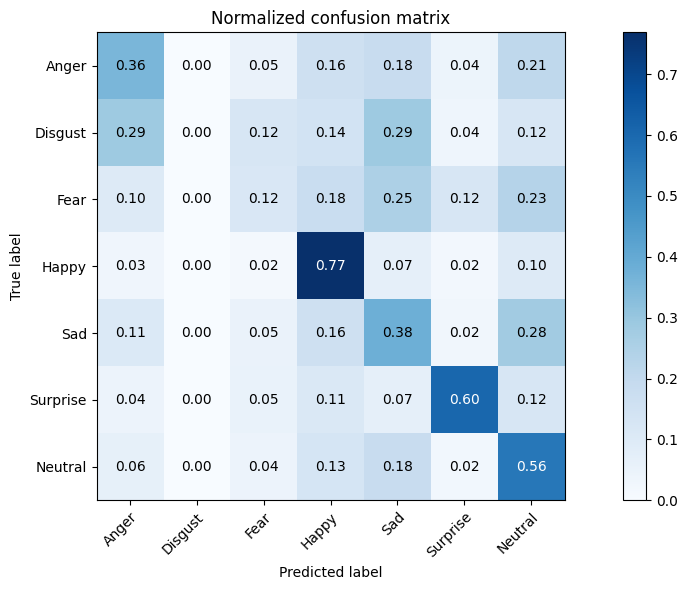

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Testing

In [ ]:
# Testing phase.
test_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, decision_function=HYPERPARAMS.decision_function, 
      gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=False)

loading dataset FER2013...
start evaluation...
loading pretrained model...
--
Validation samples: 3589
Test samples: 3589
--
evaluating...
  - test accuracy = 48.7
  - test time = 26.9 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.41      0.35      0.38       491
           1       0.00      0.00      0.00        55
           2       0.33      0.11      0.16       528
           3       0.62      0.80      0.70       879
           4       0.32      0.35      0.33       594
           5       0.61      0.58      0.59       416
           6       0.44      0.59      0.51       626

    accuracy                           0.49      3589
   macro avg       0.39      0.40      0.38      3589
weighted avg       0.46      0.49      0.46      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


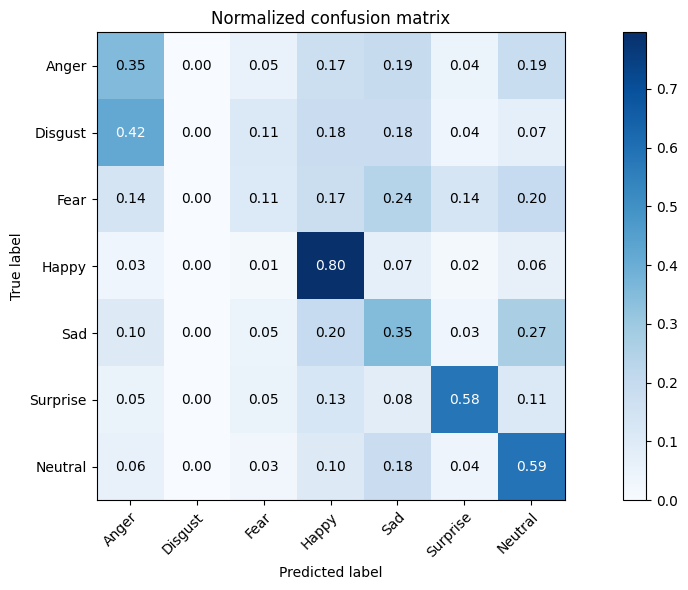

In [ ]:
# Plot normalized confusion matrix.
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Hyperparameter optimization

**Source:** https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [ ]:
# Hyperparameter optimization combinations.
param_grid = {'C': [0.1, 1, 10], 
              'gamma': ['auto', 1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr'],
              'max_iter': [1000]} 

# Load data.
train, validation = load_data(validation=True, test=False)

# Create grid.
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
# Fit the model for grid search.
grid.fit(train['X'], train['Y'])

In [ ]:
# Print best parameter after tuning.
print(grid.best_params_)

{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': 1000}


## SVM with hog features

### Training and validation

In [ ]:
# Set training hyperparameters.
class Dataset:
    name = 'FER2013'
    train_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_hog/Training'
    validation_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_hog/PublicTest'
    test_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_hog/PrivateTest'
    trunc_trainset_to = -1
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Hyperparams:
    random_state = 0
    epochs = 10000
    kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
    decision_function = 'ovr'  #'ovo' for OneVsOne and 'ovr' for OneVsRest'
    features = 'hog' # 'landmarks', 'hog' or 'landmarks_and_hog'
    gamma = 1
    C = 1 

class Training:
    save_model = True
    save_model_path = "/content/drive/MyDrive/TFG_FER/SVM/svm_hog.bin"

DATASET = Dataset()
TRAINING = Training()
HYPERPARAMS = Hyperparams()

In [ ]:
# Training and validation phase.
training_accuracy, validation_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, 
                                                               decision_function=HYPERPARAMS.decision_function, gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=True)

loading dataset FER2013...
building model...
start training...
--
kernel: rbf
decision function: ovr 
max epochs: 10000 
gamma: 1 
C: 1 
--
Training samples: 28709
Validation samples: 3589
--


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


training time = 165.4 sec
saving model...
evaluating...
  - training accuracy = 46.0
evaluating...
  - validation accuracy = 36.6
  - validation time = 13.8 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.30      0.18      0.23       467
           1       1.00      0.02      0.04        56
           2       0.32      0.17      0.22       496
           3       0.38      0.72      0.49       895
           4       0.36      0.29      0.32       653
           5       0.49      0.29      0.37       415
           6       0.34      0.31      0.32       607

    accuracy                           0.37      3589
   macro avg       0.46      0.28      0.28      3589
weighted avg       0.37      0.37      0.34      3589



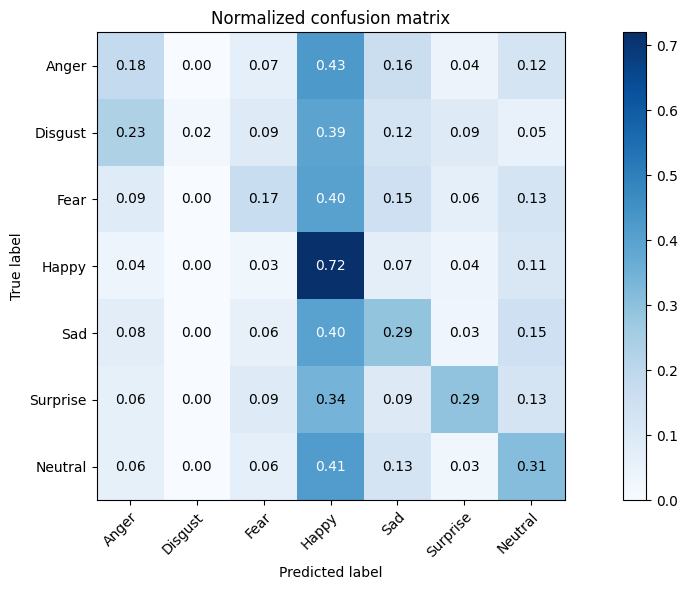

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Testing

In [ ]:
# Testing phase.
test_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, decision_function=HYPERPARAMS.decision_function, 
      gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=False)

loading dataset FER2013...
start evaluation...
loading pretrained model...
--
Validation samples: 3589
Test samples: 3589
--
evaluating...
  - test accuracy = 35.3
  - test time = 21.6 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.31      0.18      0.23       491
           1       0.00      0.00      0.00        55
           2       0.28      0.14      0.19       528
           3       0.38      0.71      0.50       879
           4       0.31      0.29      0.30       594
           5       0.49      0.29      0.36       416
           6       0.32      0.29      0.30       626

    accuracy                           0.35      3589
   macro avg       0.30      0.27      0.27      3589
weighted avg       0.34      0.35      0.33      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


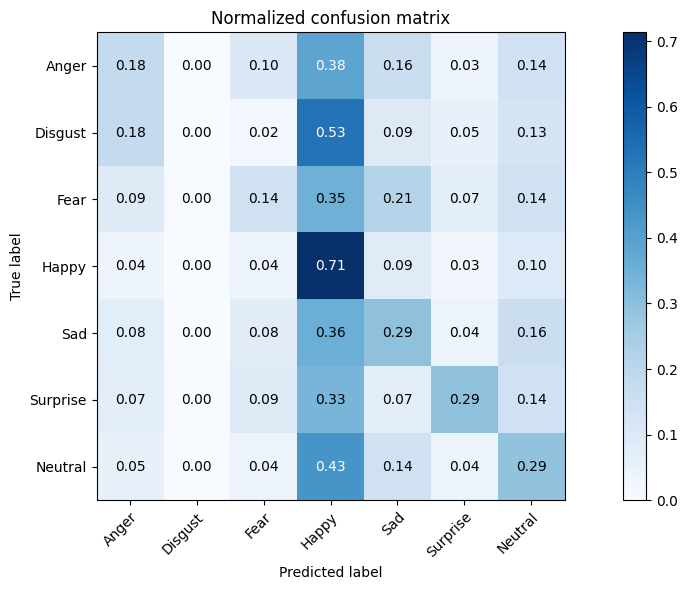

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization combinations.
param_grid = {'C': [0.1, 1, 10], 
              'gamma': ['auto', 1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr'],
              'max_iter': [1000]} 

# Load data.
train, validation = load_data(validation=True, test=False)

# Create grid.
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
# Fit the model for grid search.
grid.fit(train['X'], train['Y'])

In [ ]:
# Print best parameter after tuning.
print(grid.best_params_)

{'C': 1, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'rbf', 'max_iter': 1000}


## SVM with hog sliding window

### Training and validation

In [ ]:
# Set training hyperparameters.
class Dataset:
    name = 'FER2013'
    train_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_hog_windows/Training'
    validation_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_hog_windows/PublicTest'
    test_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_hog_windows/PrivateTest'
    trunc_trainset_to = -1
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Hyperparams:
    random_state = 0
    epochs = 10000
    kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
    decision_function = 'ovr'  #'ovo' for OneVsOne and 'ovr' for OneVsRest'
    features = 'hog' # 'landmarks', 'hog' or 'landmarks_and_hog'
    gamma = 0.01
    C = 1 

class Training:
    save_model = True
    save_model_path = "/content/drive/MyDrive/TFG_FER/SVM/svm_hog_windows.bin"

DATASET = Dataset()
TRAINING = Training()
HYPERPARAMS = Hyperparams()

In [ ]:
# Training and validation phase.
training_accuracy, validation_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, 
                                                               decision_function=HYPERPARAMS.decision_function, gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=True)

loading dataset FER2013...
building model...
start training...
--
kernel: rbf
decision function: ovr 
max epochs: 10000 
gamma: 0.01 
C: 1 
--
Training samples: 28709
Validation samples: 3589
--
training time = 2410.0 sec
saving model...
evaluating...
  - training accuracy = 68.1
evaluating...
  - validation accuracy = 50.0
  - validation time = 307.5 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.40      0.36      0.38       467
           1       1.00      0.12      0.22        56
           2       0.38      0.22      0.28       496
           3       0.58      0.78      0.67       895
           4       0.39      0.40      0.40       653
           5       0.72      0.59      0.65       415
           6       0.45      0.51      0.48       607

    accuracy                           0.50      3589
   macro avg       0.56      0.43      0.44      3589
weighted avg       0.50      0.50      0.49      3589



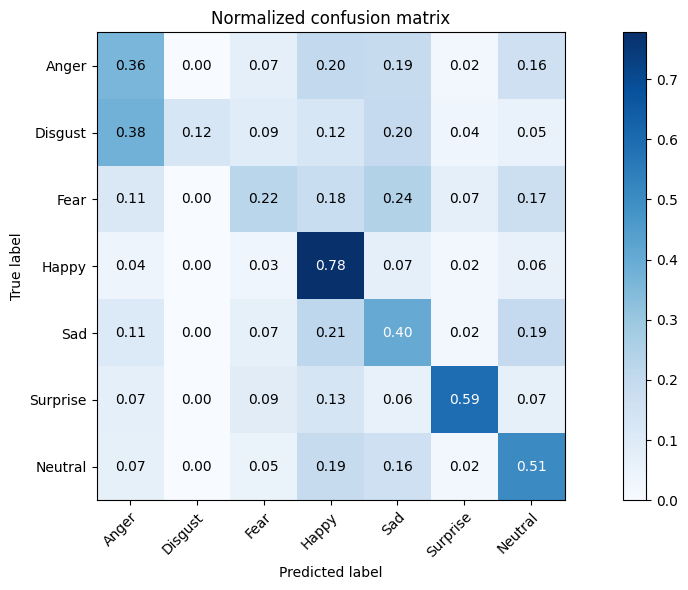

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Testing

In [ ]:
# Testing phase.
test_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, decision_function=HYPERPARAMS.decision_function, 
      gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=False)

loading dataset FER2013...
start evaluation...
loading pretrained model...
--
Validation samples: 3589
Test samples: 3589
--
evaluating...
  - test accuracy = 49.2
  - test time = 324.8 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.41      0.33      0.36       491
           1       1.00      0.11      0.20        55
           2       0.42      0.26      0.32       528
           3       0.58      0.79      0.67       879
           4       0.34      0.40      0.37       594
           5       0.69      0.54      0.61       416
           6       0.47      0.49      0.48       626

    accuracy                           0.49      3589
   macro avg       0.56      0.42      0.43      3589
weighted avg       0.49      0.49      0.48      3589



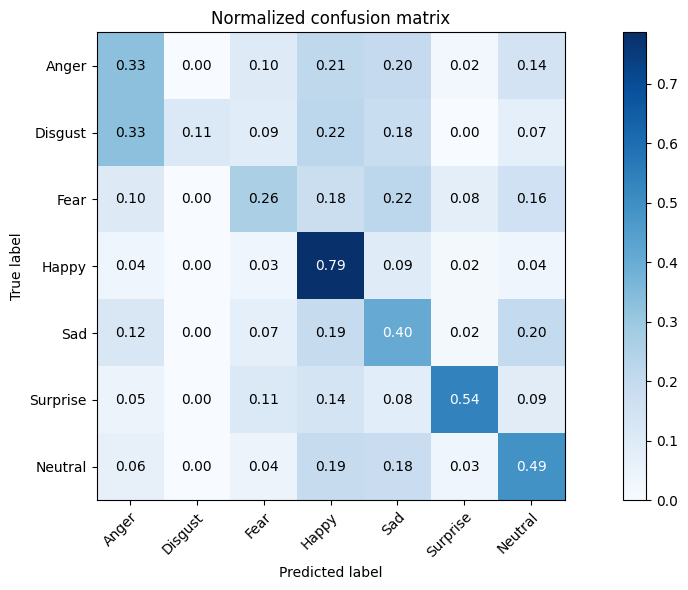

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization combinations.
param_grid = {'C': [0.1, 1, 10], 
              'gamma': ['auto', 1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr'],
              'max_iter': [1000]} 

# Load data.
train, validation = load_data(validation=True, test=False)

# Create grid.
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
# Fit the model for grid search.
grid.fit(train['X'], train['Y'])

In [ ]:
# Print best parameter after tuning.
print(grid.best_params_)

{'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 500}


## SVM with landmarks + hog

### Training and validation

In [ ]:
# Set training hyperparameters.
class Dataset:
    name = 'FER2013'
    train_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks_hog/Training'
    validation_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks_hog/PublicTest'
    test_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks_hog/PrivateTest'
    trunc_trainset_to = -1
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Hyperparams:
    random_state = 0
    epochs = 10000
    kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
    decision_function = 'ovr'  #'ovo' for OneVsOne and 'ovr' for OneVsRest'
    features = 'landmarks_and_hog' # 'landmarks', 'hog' or 'landmarks_and_hog'
    gamma = 0.0001
    C = 10 

class Training:
    save_model = True
    save_model_path = "/content/drive/MyDrive/TFG_FER/SVM/svm_landmarks_hog.bin"

DATASET = Dataset()
TRAINING = Training()
HYPERPARAMS = Hyperparams()

In [ ]:
# Training and validation phase.
training_accuracy, validation_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, 
                                                               decision_function=HYPERPARAMS.decision_function, gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=True)

loading dataset FER2013...
building model...
start training...
--
kernel: rbf
decision function: ovr 
max epochs: 10000 
gamma: 0.0001 
C: 10 
--
Training samples: 28709
Validation samples: 3589
--


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


training time = 288.9 sec
saving model...
evaluating...
  - training accuracy = 51.3
evaluating...
  - validation accuracy = 48.7
  - validation time = 33.0 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.43      0.35      0.39       467
           1       0.00      0.00      0.00        56
           2       0.31      0.11      0.17       496
           3       0.63      0.77      0.69       895
           4       0.37      0.38      0.37       653
           5       0.66      0.60      0.63       415
           6       0.39      0.56      0.46       607

    accuracy                           0.49      3589
   macro avg       0.40      0.40      0.39      3589
weighted avg       0.46      0.49      0.46      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


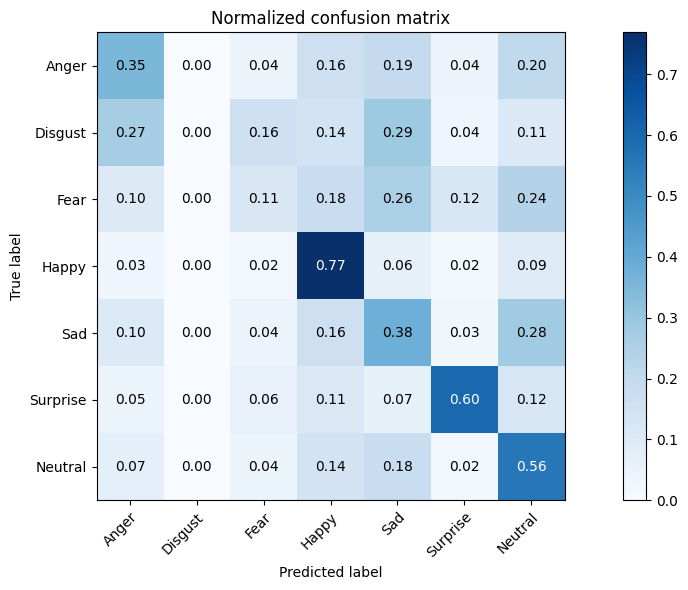

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Testing

In [ ]:
# Testing phase.
test_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, decision_function=HYPERPARAMS.decision_function, 
      gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=False)

loading dataset FER2013...
start evaluation...
loading pretrained model...
--
Validation samples: 3589
Test samples: 3589
--
evaluating...
  - test accuracy = 48.9
  - test time = 33.0 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.41      0.35      0.37       491
           1       0.00      0.00      0.00        55
           2       0.32      0.11      0.16       528
           3       0.63      0.80      0.70       879
           4       0.33      0.36      0.34       594
           5       0.61      0.58      0.59       416
           6       0.45      0.60      0.51       626

    accuracy                           0.49      3589
   macro avg       0.39      0.40      0.38      3589
weighted avg       0.46      0.49      0.46      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


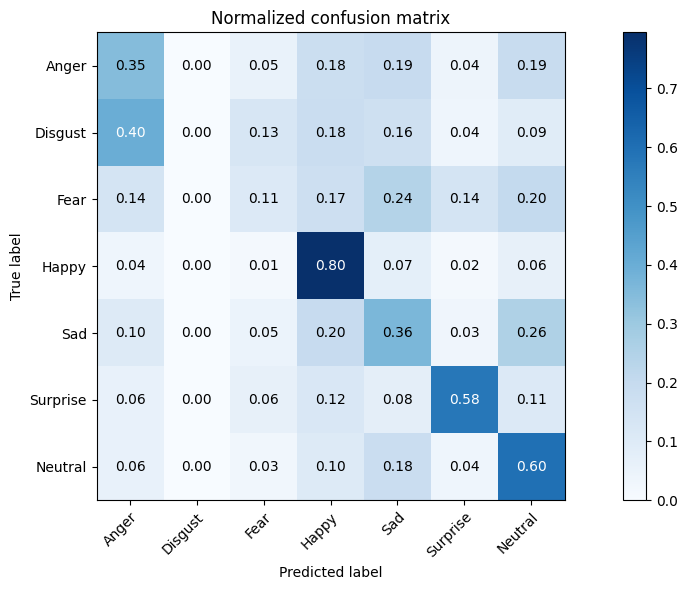

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization combinations.
param_grid = {'C': [0.1, 1, 10], 
              'gamma': ['auto', 1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr'],
              'max_iter': [1000]} 

# Load data.
train, validation = load_data(validation=True, test=False)

# Create grid.
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
# Fit the model for grid search.
grid.fit(train['X'], train['Y'])

In [ ]:
# Print best parameter after tuning.
print(grid.best_params_)

{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': 1000}


## SVM with landmarks + hog sliding window

### Training and validation

In [ ]:
# Set training hyperparameters.
class Dataset:
    name = 'FER2013'
    train_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks_hog_windows/Training'
    validation_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks_hog_windows/PublicTest'
    test_folder = '/content/drive/MyDrive/TFG_FER/Extracted_Features/fer2013_landmarks_hog_windows/PrivateTest'
    trunc_trainset_to = -1
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Hyperparams:
    random_state = 0
    epochs = 10000
    kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
    decision_function = 'ovr'  #'ovo' for OneVsOne and 'ovr' for OneVsRest'
    features = 'landmarks_and_hog' # 'landmarks', 'hog' or 'landmarks_and_hog'
    gamma = 0.0001
    C = 10 

class Training:
    save_model = True
    save_model_path = "/content/drive/MyDrive/TFG_FER/SVM/svm_landmarks_hog_windows.bin"

DATASET = Dataset()
TRAINING = Training()
HYPERPARAMS = Hyperparams()

In [ ]:
# Training and validation phase.
training_accuracy, validation_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, 
                                                               decision_function=HYPERPARAMS.decision_function, gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=True)

loading dataset FER2013...
building model...
start training...
--
kernel: rbf
decision function: ovr 
max epochs: 5000 
gamma: 0.0001 
C: 10 
--
Training samples: 28709
Validation samples: 3589
--


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


training time = 1943.7 sec
saving model...
evaluating...
  - training accuracy = 56.7
evaluating...
  - validation accuracy = 52.3
  - validation time = 303.2 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       467
           1       0.00      0.00      0.00        56
           2       0.39      0.18      0.25       496
           3       0.66      0.79      0.72       895
           4       0.38      0.42      0.40       653
           5       0.71      0.66      0.68       415
           6       0.44      0.57      0.50       607

    accuracy                           0.52      3589
   macro avg       0.44      0.43      0.42      3589
weighted avg       0.51      0.52      0.51      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


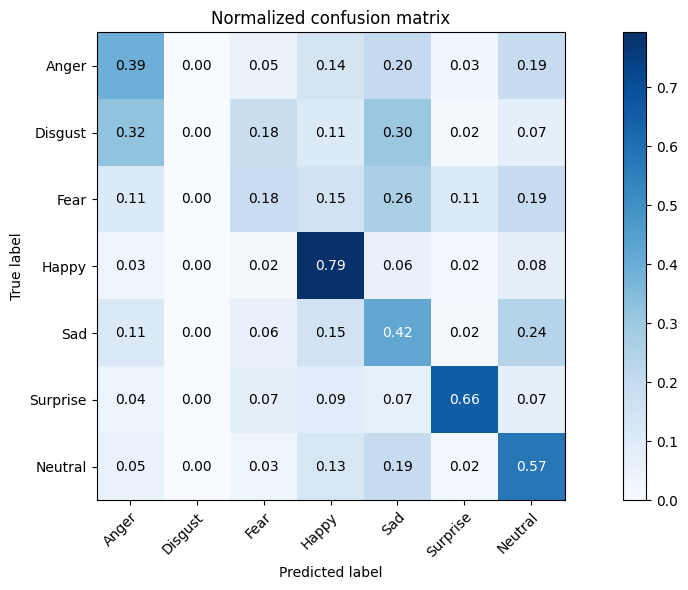

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Testing

In [ ]:
# Testing phase.
test_accuracy, Y_true, Y_pred = train(epochs=HYPERPARAMS.epochs, random_state=HYPERPARAMS.random_state, kernel=HYPERPARAMS.kernel, decision_function=HYPERPARAMS.decision_function, 
      gamma=HYPERPARAMS.gamma, C=HYPERPARAMS.C , train_model=False)

loading dataset FER2013...
start evaluation...
loading pretrained model...
--
Validation samples: 3589
Test samples: 3589
--
evaluating...
  - test accuracy = 51.8
  - test time = 315.4 sec


In [ ]:
# Classification report.
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.42      0.40      0.41       491
           1       0.00      0.00      0.00        55
           2       0.33      0.17      0.22       528
           3       0.67      0.82      0.74       879
           4       0.35      0.39      0.37       594
           5       0.67      0.60      0.63       416
           6       0.50      0.59      0.54       626

    accuracy                           0.52      3589
   macro avg       0.42      0.42      0.42      3589
weighted avg       0.49      0.52      0.50      3589



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


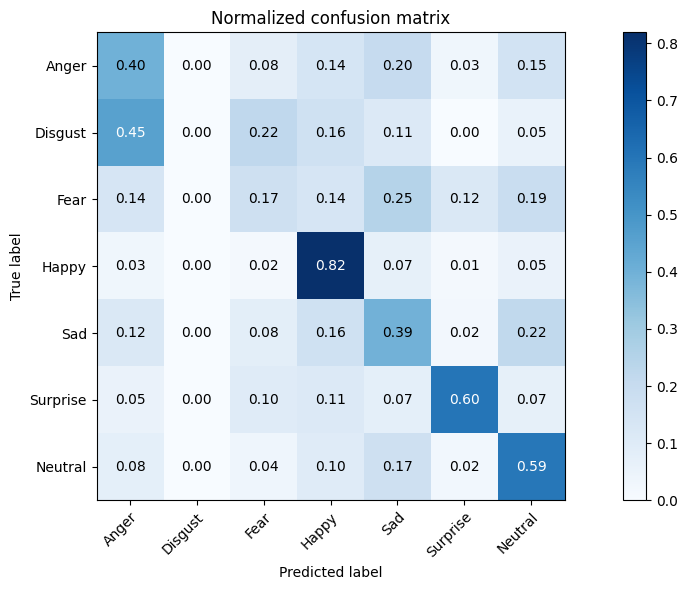

In [ ]:
# Plot normalized confusion matrix.
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plot_confusion_matrix(Y_true, Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Hyperparameter optimization

In [ ]:
# Hyperparameter optimization combinations.
param_grid = {'C': [0.1, 1, 10], 
              'gamma': ['auto', 1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr'],
              'max_iter': [500]} 

# Load data.
train, validation = load_data(validation=True, test=False)

# Create grid.
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
# Fit the model for grid search.
grid.fit(train['X'], train['Y'])

In [ ]:
# Print best parameter after tuning.
print(grid.best_params_)

{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': 500}


## Bibliography


*   https://github.com/amineHorseman/facial-expression-recognition-svm/blob/master/convert_fer2013_to_images_and_landmarks.py 

